In [1]:
# install python library
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00


In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats

In [3]:
# load cleaned data CSV
df = pd.read_csv("/content/mortgage_df.csv")
df = df.drop(columns=['Unnamed: 0']) # drop unnecessary column
df['Week'] = pd.to_datetime(df['Week']) # convert week to datetime format
df.set_index('Week', inplace=True) # set week as index
df

,U.S. 30 yr FRM,U.S. 15 yr FRM
Week,,
1991-08-30,9.15,8.77
1991-09-06,9.14,8.79
1991-09-13,9.02,8.68
1991-09-20,8.95,8.62
1991-09-27,8.92,8.59
...,...,...
2024-10-17,6.44,5.63
2024-10-24,6.54,5.71
2024-10-31,6.72,5.99


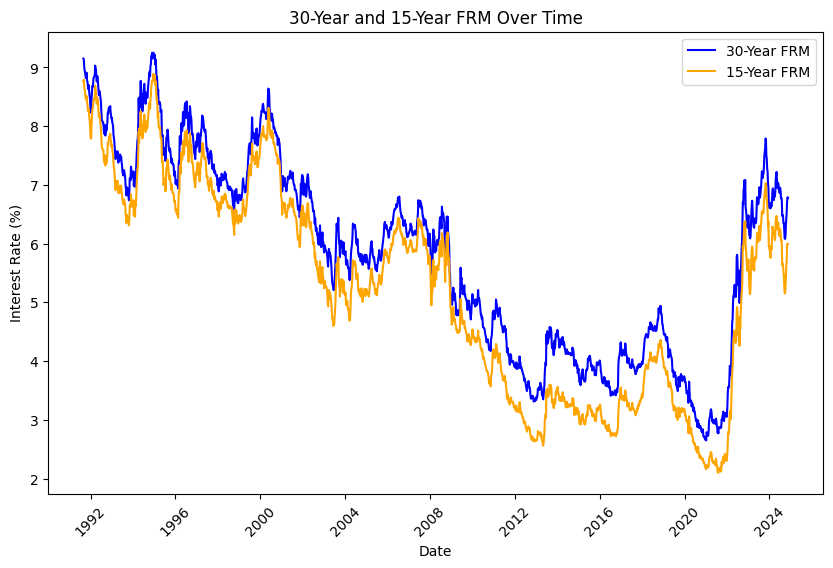

In [6]:
# explore data - plot linegraph of FRM over time

# plot the 30-yr and 15-yr FRM on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['U.S. 30 yr FRM'], label='30-Year FRM', color='blue')
plt.plot(df.index, df['U.S. 15 yr FRM'], label='15-Year FRM', color='orange')
plt.title('30-Year and 15-Year FRM Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

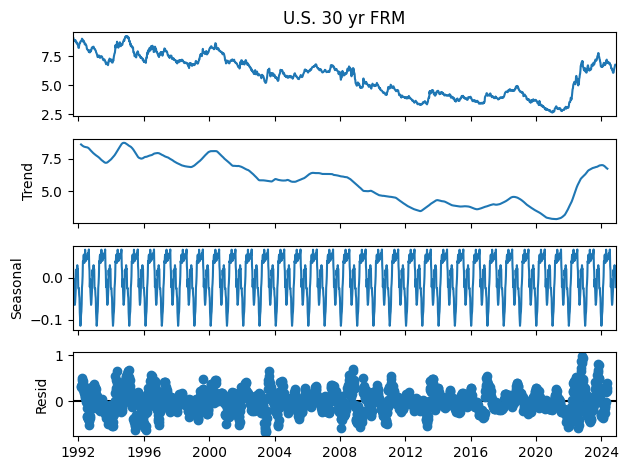

In [8]:
# apply seasonal decomposition to the 30-Year FRM data to determine if seasonal trends appear
decomposition = seasonal_decompose(df['U.S. 30 yr FRM'], model='additive', period=52) # period of 52 weeks in a year
decomposition.plot()
plt.show() # shows seasonality

<Figure size 1200x600 with 0 Axes>

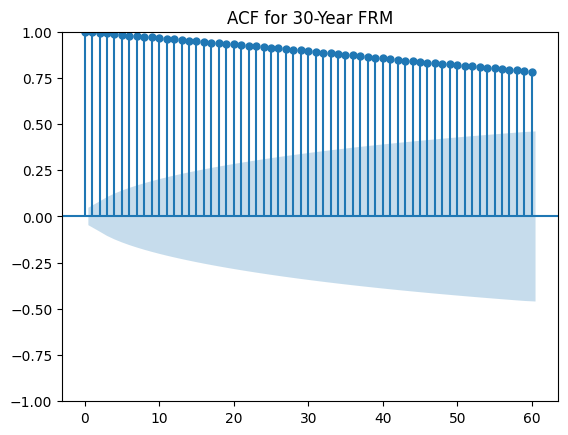

<Figure size 1200x600 with 0 Axes>

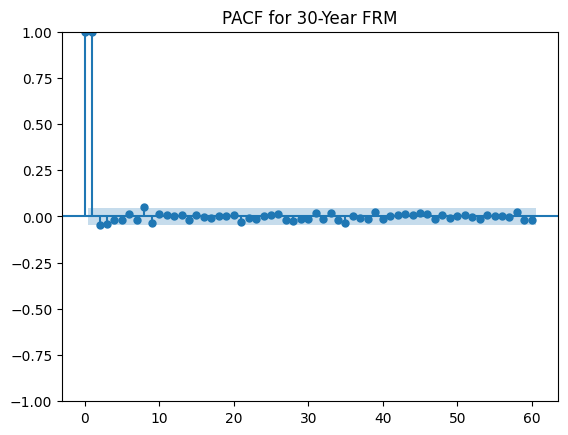

<Figure size 1200x600 with 0 Axes>

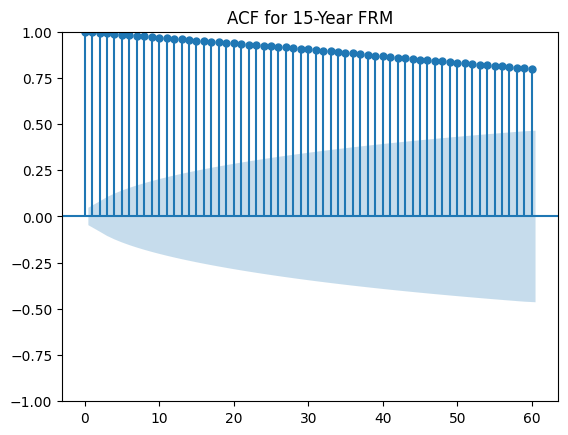

<Figure size 1200x600 with 0 Axes>

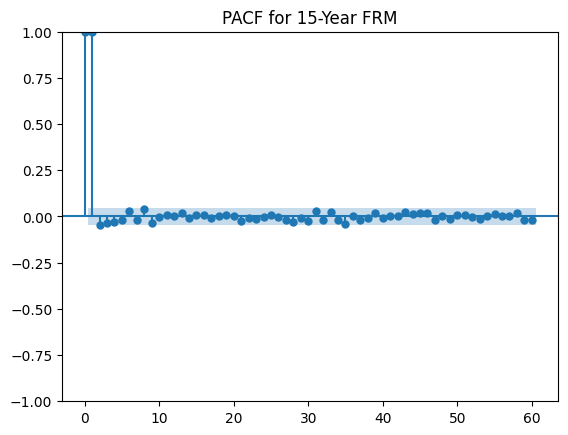

In [10]:
# plot ACF and PACF for 30-year FRM to manually determine p, d, q parameters
plt.figure(figsize=(12, 6))
plot_acf(df['U.S. 30 yr FRM'].dropna(), lags=60)
plt.title('ACF for 30-Year FRM')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['U.S. 30 yr FRM'].dropna(), lags=60)
plt.title('PACF for 30-Year FRM')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(df['U.S. 15 yr FRM'].dropna(), lags=60)
plt.title('ACF for 15-Year FRM')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['U.S. 15 yr FRM'].dropna(), lags=60)
plt.title('PACF for 15-Year FRM')
plt.show()

# 30-Year FRM: p=2, d=1, q=1 | P=1, D=1, Q=1, m=52
# 15-Year FRM: p=2, d=1, q=1 | P=1, D=1, Q=1, m=52

ADF Test for 30-Year FRM:
ADF Statistic: -2.0431249966432916
p-value: 0.2679900744359546
Data is not stationary, consider differencing

ADF Test for 15-Year FRM:
ADF Statistic: -2.0154905309548425
p-value: 0.2798226151284686
Data is not stationary, consider differencing


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


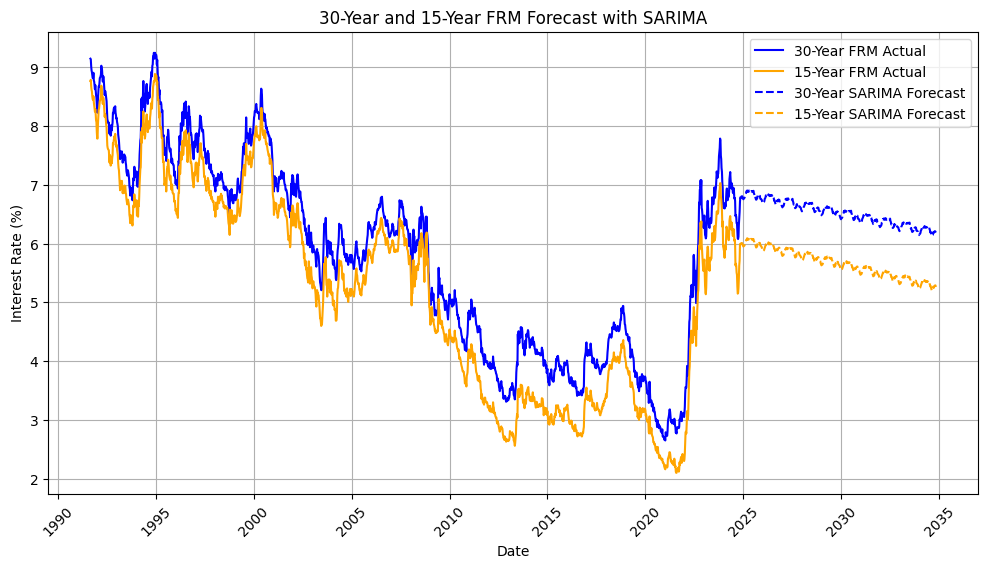

In [11]:
# plot forecast using manually determined parameters based on ACF and PACF plots

# function to do ADF test for stationarity
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary, consider differencing")

# check stationarity for both 30-year and 15-year FRM
print("ADF Test for 30-Year FRM:")
adf_test(df['U.S. 30 yr FRM'])
print("\nADF Test for 15-Year FRM:")
adf_test(df['U.S. 15 yr FRM'])

# fit ARIMA model to 30-Year FRM data
arima_30yr_model = ARIMA(df['U.S. 30 yr FRM'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 52))
arima_30yr_fit = arima_30yr_model.fit()

# fit ARIMA model to 15-Year FRM data
arima_15yr_model = ARIMA(df['U.S. 15 yr FRM'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 52))
arima_15yr_fit = arima_15yr_model.fit()

# forecast for the next 10 years
forecast_steps = 52 * 10  # 10 years of weekly data
forecast_30yr = arima_30yr_fit.predict(start=len(df), end=len(df) + forecast_steps - 1)
forecast_15yr = arima_15yr_fit.predict(start=len(df), end=len(df) + forecast_steps - 1)

# create a date range for the forecasted values to align with weekly data
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(weeks=1), periods=forecast_steps, freq='W-THU')

# plot SARIMA forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['U.S. 30 yr FRM'], label='30-Year FRM Actual', color='blue')
plt.plot(df.index, df['U.S. 15 yr FRM'], label='15-Year FRM Actual', color='orange')
plt.plot(forecast_index, forecast_30yr, label='30-Year SARIMA Forecast', color='blue', linestyle='--')
plt.plot(forecast_index, forecast_15yr, label='15-Year SARIMA Forecast', color='orange', linestyle='--')
plt.title('30-Year and 15-Year FRM Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

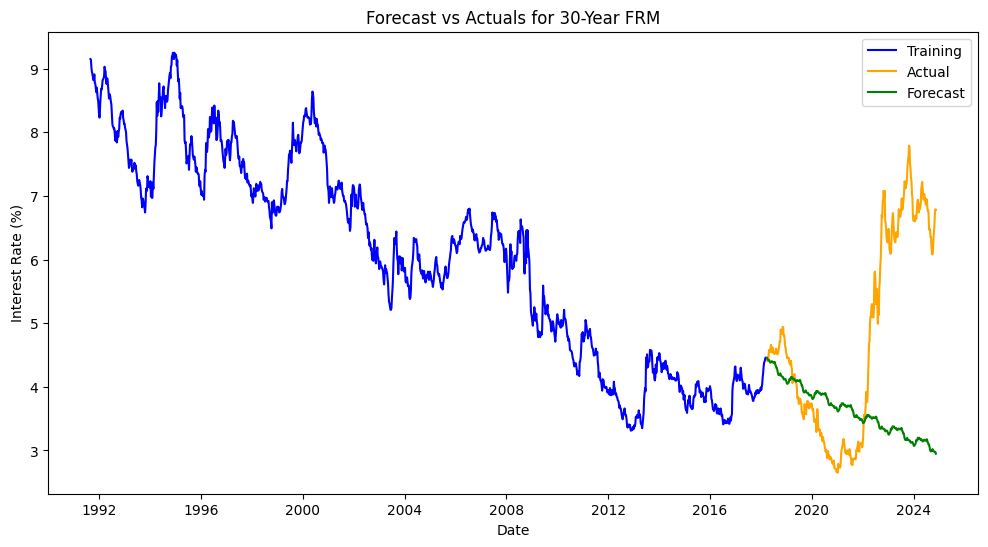

In [14]:
# compare forecasted values with actual data to check model accuracy

# split the data into train and test sets
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
train_data, test_data = df[:train_size], df[train_size:]

# manual SARIMA for 30-Year FRM
sarima_30yr_model = ARIMA(train_data['U.S. 30 yr FRM'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_30yr_fit = sarima_30yr_model.fit()

# forecast for the test set period
forecast_30yr = sarima_30yr_fit.predict(start=len(train_data), end=len(df) - 1)

# plot historical, forecasted and actual data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['U.S. 30 yr FRM'], label='Training', color='blue')
plt.plot(test_data.index, test_data['U.S. 30 yr FRM'], label='Actual', color='orange')
plt.plot(test_data.index, forecast_30yr, label='Forecast', color='green')
plt.title('Forecast vs Actuals for 30-Year FRM')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

In [15]:
# calculate MAE and RMSE values to assess model
mae = mean_absolute_error(test_data['U.S. 30 yr FRM'], forecast_30yr)
rmse = np.sqrt(mean_squared_error(test_data['U.S. 30 yr FRM'], forecast_30yr))

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Mean Absolute Error (MAE): 1.579
Root Mean Squared Error (RMSE): 2.143
